## __1- Data Loading & Checking__

### 1.1- Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import xgboost as xgb
import shap
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

### 1.2- Loading the Dataset

In [ ]:
loan_data = pd.read_csv('data/loan_data.csv')
print(loan_data.head().to_markdown())

|    |   person_age | person_gender   | person_education   |   person_income |   person_emp_exp | person_home_ownership   |   loan_amnt | loan_intent   |   loan_int_rate |   loan_percent_income |   cb_person_cred_hist_length |   credit_score | previous_loan_defaults_on_file   |   loan_status |
|---:|-------------:|:----------------|:-------------------|----------------:|-----------------:|:------------------------|------------:|:--------------|----------------:|----------------------:|-----------------------------:|---------------:|:---------------------------------|--------------:|
|  0 |           22 | female          | Master             |           71948 |                0 | RENT                    |       35000 | PERSONAL      |           16.02 |                  0.49 |                            3 |            561 | No                               |             1 |
|  1 |           21 | female          | High School        |           12282 |                0 | OWN              

### 1.3- Initial Inspection

In [ ]:
# Initial Exploration/ Info
def initial_data_check(df):
    print("Dataset Info:")
    print(df.info())

    print("\nMissing Values:")
    print(df.isnull().sum())

    print("\nSummary Statistics:")
    print(df.describe())

    print("\nCategorical Features Summary:")
    for col in df.select_dtypes(include=['object']).columns:
        print(f"{col}: {df[col].unique()}")

In [ ]:
initial_data_check(loan_data)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defa

> - No Missing Values: All 45,000 records have complete data across 14 columns.
> - Proper Data Types: Numerical and categorical columns are correctly classified.

## __2- Exploratory Data Analysis__

### 2.1- Bi-Variate Analysis

- _Loan Approval Rate BY (person_gender, person_education, loan_intent, home_ownership)_

In [ ]:
# Bivariate Analysis
# Loan Approval Rates by Categorical Features
def plot_loan_approval_rates(df, categorical_cols):
    plt.figure(figsize=(14, 8))
    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(2, 2, i)
        approval_rates = df.groupby(col)['loan_status'].mean() * 100
        sns.barplot(x=approval_rates.index, y=approval_rates.values, hue=approval_rates.index, palette='coolwarm', legend=False)
        plt.title(f'Loan Approval Rate by {col}')
        plt.ylabel('Approval Rate (%)')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

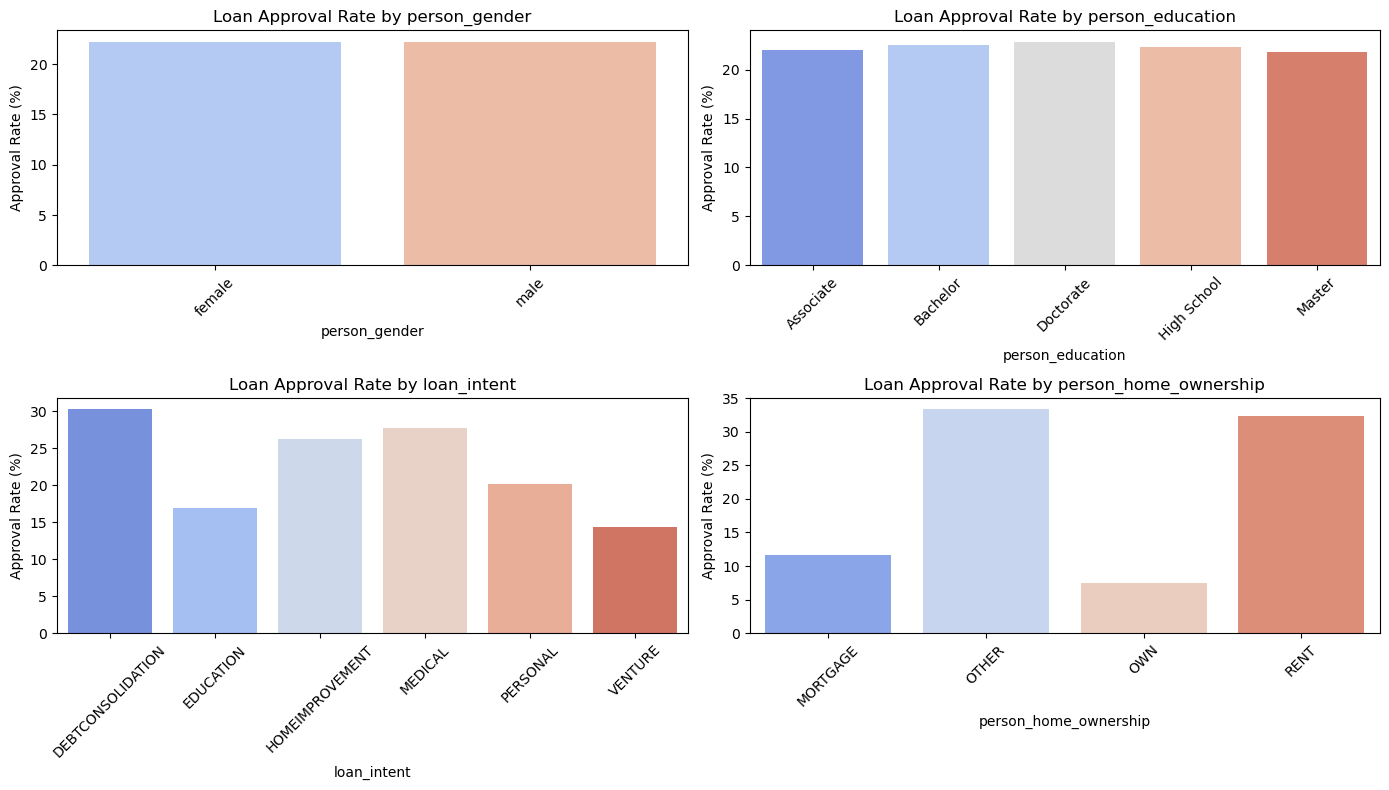

In [ ]:
categorical_features = ['person_gender', 'person_education', 'loan_intent', 'person_home_ownership']
plot_loan_approval_rates(loan_data, categorical_features)

> - Gender & Education: No major impact on loan approval rates.
> - Loan Intent: Debt Consolidation loans have the highest approval, Education & Venture loans the lowest.
> - Home Ownership: Renters get approved more than homeowners & mortgage holders, possibly due to existing debts.

- _Loan approval based on previous loan defaults_

In [ ]:
# Bivariate Analysis
# Stacked Bar Chart for Previous Loan Defaults
def plot_previous_loan_defaults(df):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x='previous_loan_defaults_on_file', hue='loan_status', palette='coolwarm')
    plt.title('Loan Approval Based on Previous Loan Defaults')
    plt.xlabel('Previous Loan Defaults')
    plt.ylabel('Count')
    plt.legend(['Rejected', 'Approved'], loc='upper right')
    plt.xticks(rotation=0)
    plt.show()

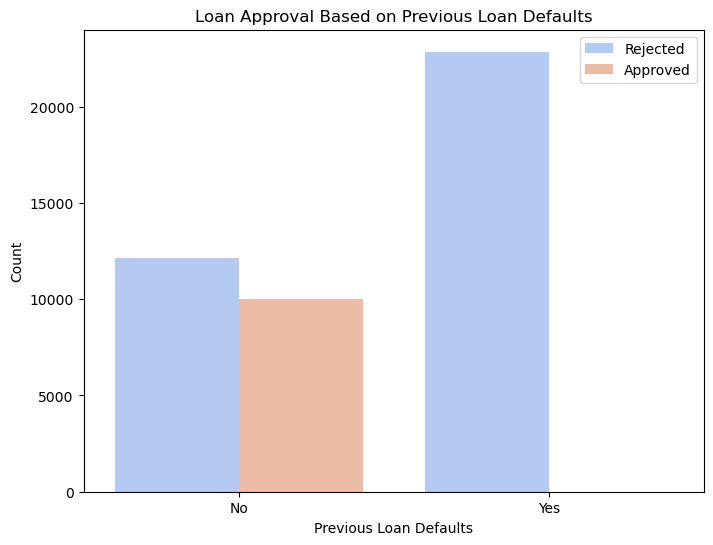

In [ ]:
plot_previous_loan_defaults(loan_data)

> - Applicants with previous loan defaults have a significantly lower approval rate.
> - Most defaulters get rejected, indicating that past credit behavior strongly influences approval.
> - Non-defaulters have a much higher chance of loan approval.

- _Person Income, Credit Score, Loan Amount_

In [ ]:
# Bivariate Analysis
# Box Plots for Income, Credit Score, and Loan Amount

def plot_box_plots(df, numerical_cols):
    plt.figure(figsize=(18, 6))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(1, 3, i)
        sns.boxplot(x='loan_status', y=df[col], data=df, hue='loan_status', palette='coolwarm', legend=False)
        plt.title(f'Loan Approval by {col}')
        plt.xlabel('Loan Status (0 = Rejected, 1 = Approved)')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()

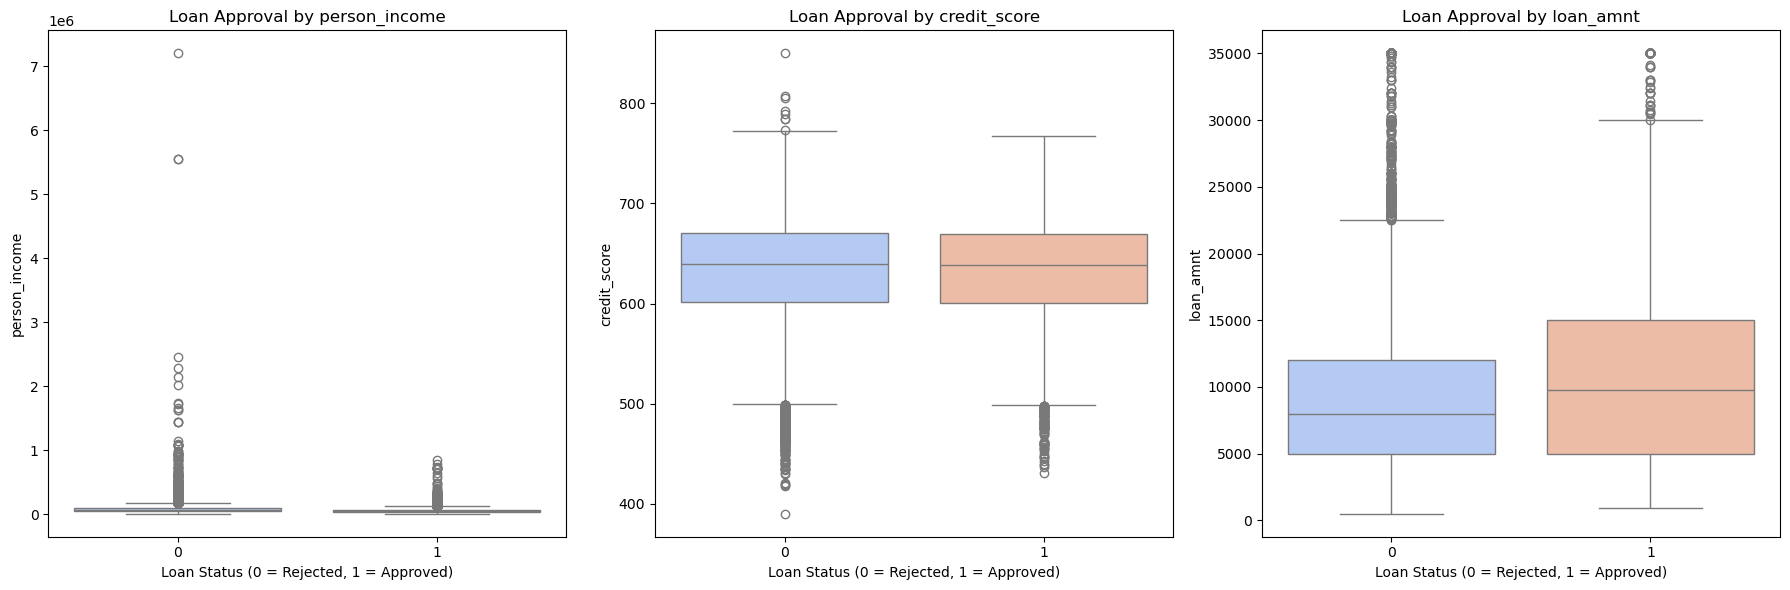

In [ ]:
numerical_features = ['person_income', 'credit_score', 'loan_amnt']
plot_box_plots(loan_data, numerical_features)

> - __Income & Loan Approval:__ Approved and rejected applicants have similar income ranges, but extreme high-income outliers exist.
> - __Credit Score Impact:__ Higher credit scores correlate with approvals, while many rejected applicants have scores below 600.
> - __Loan Amount & Approval:__ Approved loans tend to have higher amounts than rejected ones, indicating that larger loans are still considered for approval.

- _Loan Approval by Loan Percent Income_

In [ ]:
# Bivariate Analysis
# Violin Plot for Loan Percent Income
def plot_violin_loan_percent_income(df):
    plt.figure(figsize=(8, 6))
    sns.violinplot(x='loan_status', y='loan_percent_income', data=df, hue='loan_status', palette='coolwarm', legend=False)
    plt.title('Loan Approval by Loan Percent Income')
    plt.xlabel('Loan Status (0 = Rejected, 1 = Approved)')
    plt.ylabel('Loan Percent Income')
    plt.show()

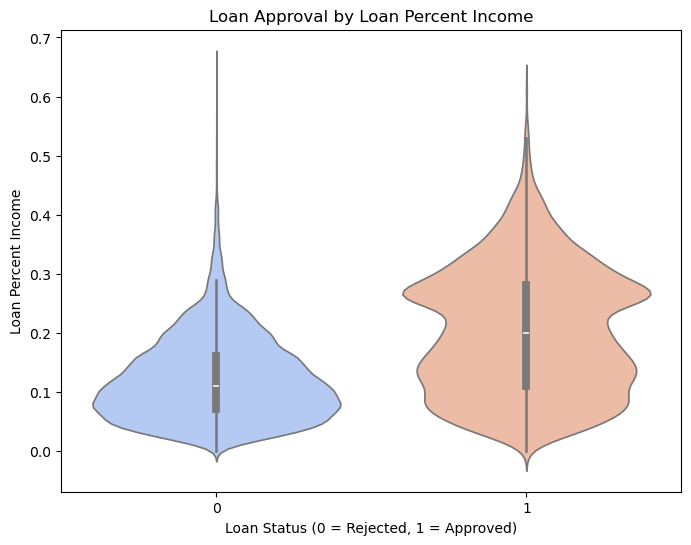

In [ ]:
plot_violin_loan_percent_income(loan_data)

> - Higher Debt-to-Income Ratio → More Rejections
> - Approved Loans Mostly Fall in the 10-30% Range
> - Rejections Increase for Ratios Above 40%

- _Loan Interest Rate Distribution by Loan Status_

In [ ]:
# Bivariate Analysis
# KDE Plot for Loan Interest Rate
def plot_kde_loan_interest_rate(df):
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df[df['loan_status'] == 1]['loan_int_rate'], label='Approved', fill=True, color='blue')
    sns.kdeplot(df[df['loan_status'] == 0]['loan_int_rate'], label='Rejected', fill=True, color='red')
    plt.title('Loan Interest Rate Distribution by Loan Status')
    plt.xlabel('Loan Interest Rate (%)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

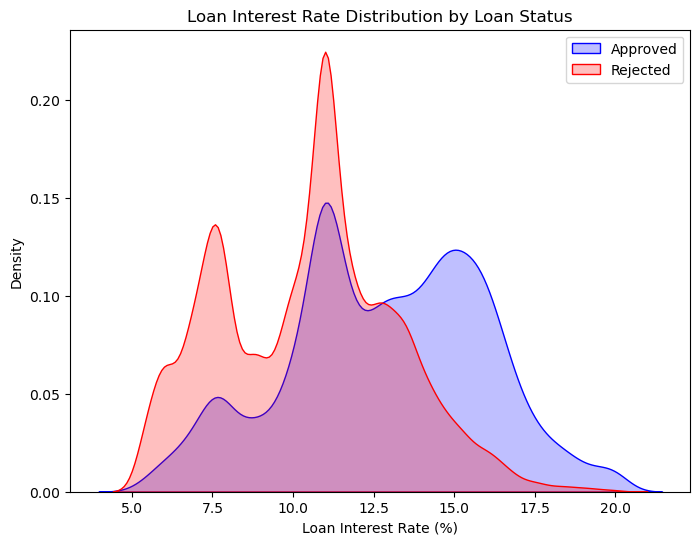

In [ ]:
plot_kde_loan_interest_rate(loan_data)

> - Higher interest rates → More rejections.
> - Approved loans cluster around 10-15%, while rejected loans peak around 10% but extend lower.
> - Lower interest rates (<8%) are mostly rejected, indicating higher-risk borrowers with lower rates might still get denied.

### 2.2- Loan Approval Overview

In [ ]:
# Loan Approval Overview Analysis
def loan_approval_overview(df):
    total_loans = len(df)
    approved_loans = df['loan_status'].sum()
    rejected_loans = total_loans - approved_loans

    approval_rate = (approved_loans / total_loans) * 100
    rejection_rate = (rejected_loans / total_loans) * 100

    avg_income_approved = df[df['loan_status'] == 1]['person_income'].mean()
    avg_income_rejected = df[df['loan_status'] == 0]['person_income'].mean()

    avg_credit_score_approved = df[df['loan_status'] == 1]['credit_score'].mean()
    avg_credit_score_rejected = df[df['loan_status'] == 0]['credit_score'].mean()

    avg_loan_amount_approved = df[df['loan_status'] == 1]['loan_amnt'].mean()
    avg_loan_amount_rejected = df[df['loan_status'] == 0]['loan_amnt'].mean()

    print(f"Total Loans: {total_loans}")
    print(f"Approved Loans: {approved_loans} ({approval_rate:.2f}%)")
    print(f"Rejected Loans: {rejected_loans} ({rejection_rate:.2f}%)")
    print(f"Average Income - Approved: ${avg_income_approved:.2f}, Rejected: ${avg_income_rejected:.2f}")
    print(f"Average Credit Score - Approved: {avg_credit_score_approved:.2f}, Rejected: {avg_credit_score_rejected:.2f}")
    print(f"Average Loan Amount - Approved: ${avg_loan_amount_approved:.2f}, Rejected: ${avg_loan_amount_rejected:.2f}")


In [ ]:
loan_approval_overview(loan_data)

Total Loans: 45000
Approved Loans: 10000 (22.22%)
Rejected Loans: 35000 (77.78%)
Average Income - Approved: $59886.10, Rejected: $86157.04
Average Credit Score - Approved: 631.89, Rejected: 632.81
Average Loan Amount - Approved: $10855.69, Rejected: $9219.58


> - High Rejection Rate (77.78%) → Most applicants are denied.
> - Rejected Applicants Have Higher Income → Suggests other factors (e.g., debt, credit history) impact decisions.
> - Credit Score is Similar → Approval isn’t solely based on credit score.
> - Approved Loans Have Higher Amounts → Larger loans are still granted, possibly to financially stable applicants.

### 2.3- Loan Approval vs Key Financial Metrics

In [ ]:
# Loan Approval vs. Key Financial Metrics

def plot_financial_metrics(df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Income Distribution
    sns.histplot(df[df['loan_status'] == 1]['person_income'], bins=50, color='blue', label='Approved', ax=axes[0], kde=True)
    sns.histplot(df[df['loan_status'] == 0]['person_income'], bins=50, color='red', label='Rejected', ax=axes[0], kde=True)
    axes[0].set_title('Income Distribution: Approved vs. Rejected')
    axes[0].set_xlabel('Income')
    axes[0].legend()

    # Credit Score Distribution
    sns.histplot(df[df['loan_status'] == 1]['credit_score'], bins=30, color='blue', label='Approved', ax=axes[1], kde=True)
    sns.histplot(df[df['loan_status'] == 0]['credit_score'], bins=30, color='red', label='Rejected', ax=axes[1], kde=True)
    axes[1].set_title('Credit Score Distribution: Approved vs. Rejected')
    axes[1].set_xlabel('Credit Score')
    axes[1].legend()

    # Loan Amount Distribution
    sns.histplot(df[df['loan_status'] == 1]['loan_amnt'], bins=30, color='blue', label='Approved', ax=axes[2], kde=True)
    sns.histplot(df[df['loan_status'] == 0]['loan_amnt'], bins=30, color='red', label='Rejected', ax=axes[2], kde=True)
    axes[2].set_title('Loan Amount Distribution: Approved vs. Rejected')
    axes[2].set_xlabel('Loan Amount')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

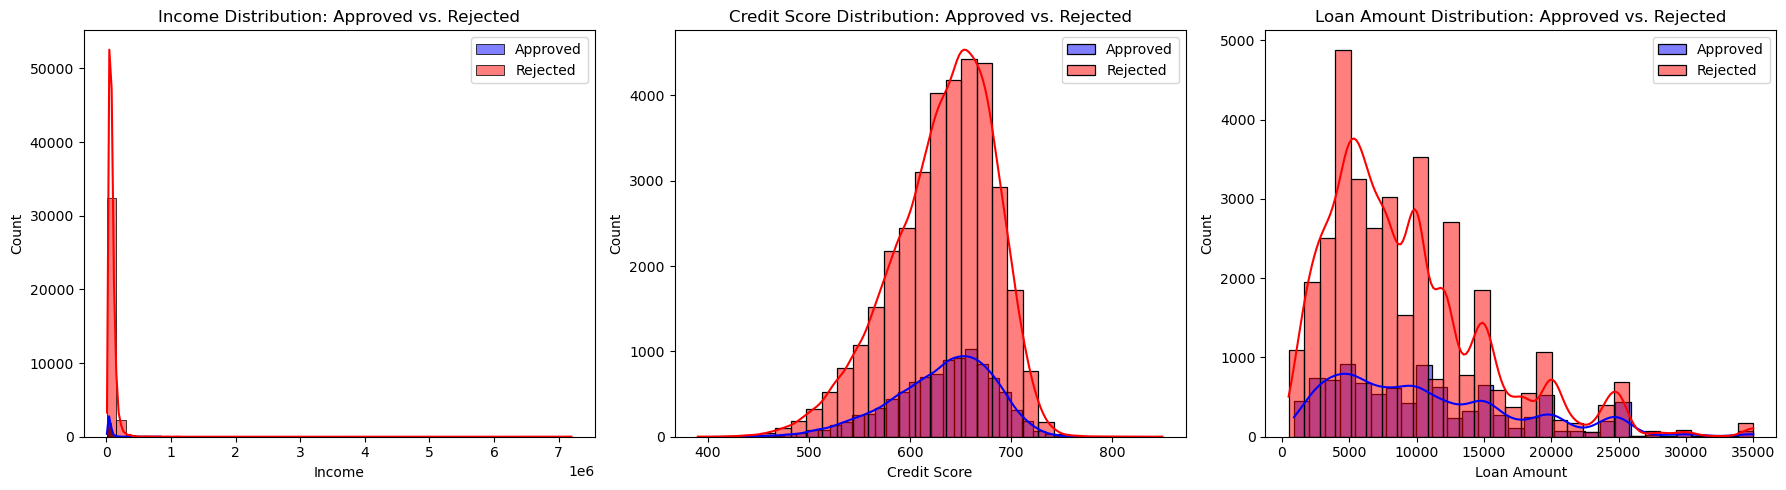

In [ ]:
plot_financial_metrics(loan_data)

> - __Income:__ Most rejected applicants have low to moderate income, but approvals exist across all income levels.
> - __Credit Score:__ Rejected loans peak around 600, while approvals are more evenly spread above 600.
> - __Loan Amount:__ Smaller loans (<10K) face higher rejection, while larger loans have a higher approval rate.

### 2.4- Categorical Feature Analysis

In [ ]:
# Categorical Feature Analysis: Loan Status by Age Group & Gender

def categorize_age(age):
    if age < 20:
        return '<20'
    elif age < 30:
        return '20-29'
    elif age < 40:
        return '30-39'
    elif age < 50:
        return '40-49'
    elif age < 60:
        return '50-59'
    else:
        return '60+'

loan_data['age_group'] = loan_data['person_age'].apply(categorize_age)

def plot_age_gender_heatmap(df):
    age_gender_pivot = df.pivot_table(index='age_group', columns='person_gender', values='loan_status', aggfunc='mean') * 100

    plt.figure(figsize=(8, 6))
    sns.heatmap(age_gender_pivot, annot=True, cmap='coolwarm', fmt=".1f")
    plt.title('Loan Approval Rate by Age Group & Gender')
    plt.xlabel('Gender')
    plt.ylabel('Age Group')
    plt.show()

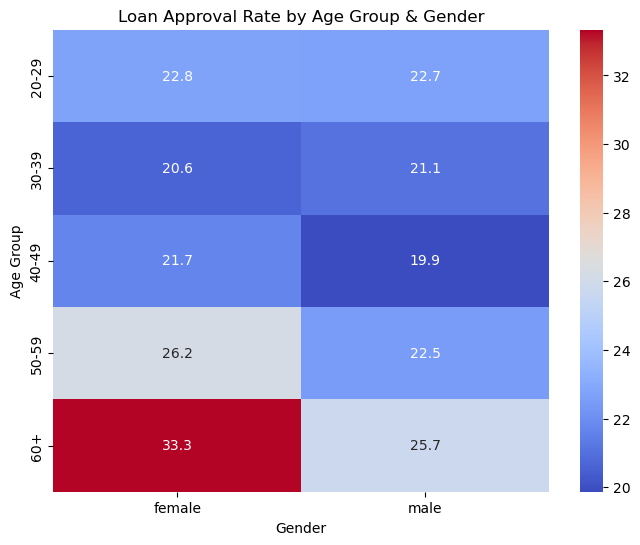

In [ ]:
plot_age_gender_heatmap(loan_data)

> - Approval rates increase with age, highest for 60+ (33.3% for females, 25.7% for males).
> - Lowest approval rates in the 30-49 range, especially for males aged 40-49 (19.9%).
> - Gender has minimal impact overall, but older females receive the highest approvals.

In [ ]:
# Categorical Feature Analysis
# Education Level & Loan Intent vs. Loan Status
def plot_education_loan_intent(df):
    plt.figure(figsize=(12, 6))

    # Grouping by Education & Loan Intent to calculate approval rates
    approval_rates = df.groupby(['person_education', 'loan_intent'])['loan_status'].mean() * 100
    approval_rates = approval_rates.unstack()

    # Creating a clustered bar chart
    approval_rates.plot(kind='bar', figsize=(12, 6), colormap='coolwarm', edgecolor='black')
    plt.title('Loan Approval Rate by Education Level & Loan Intent')
    plt.xlabel('Education Level')
    plt.ylabel('Approval Rate (%)')
    plt.xticks(rotation=45)
    plt.legend(title="Loan Intent", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

<Figure size 1200x600 with 0 Axes>

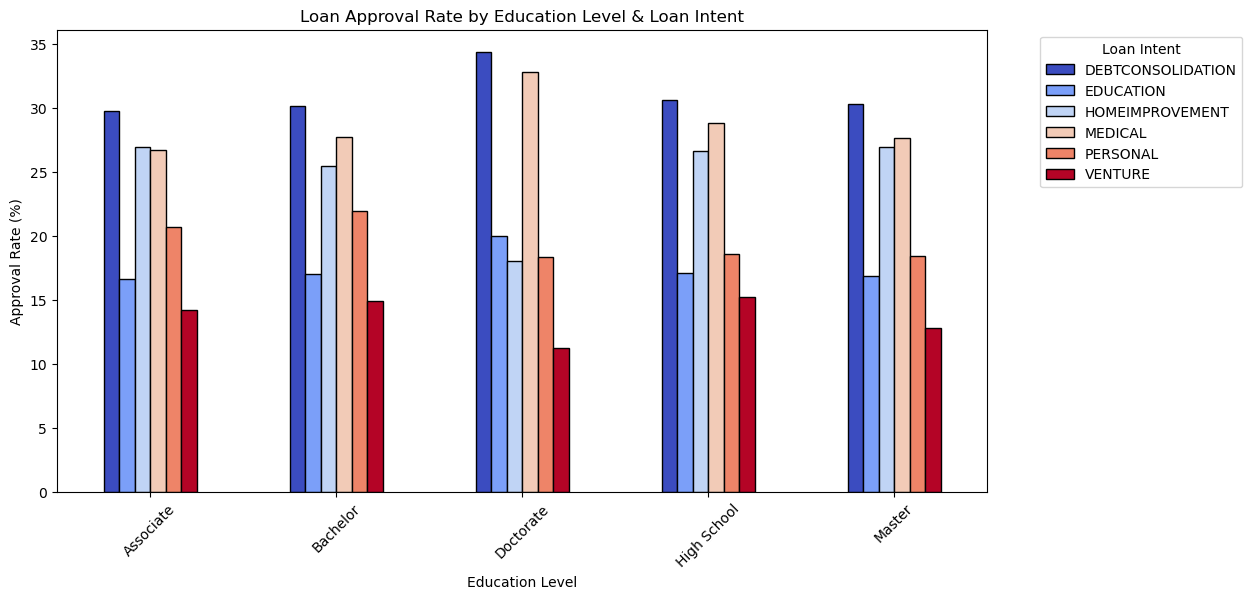

In [ ]:
plot_education_loan_intent(loan_data)

> - Debt Consolidation & Medical loans have the highest approval rates, regardless of education level.
> - Education & Venture loans have the lowest approval rates, especially for Doctorate holders.
> - Approval rates are fairly consistent across education levels, meaning education alone isn't a strong approval factor

In [ ]:
# Categorical Feature Analysis
# Home Ownership & Previous Loan Defaults Impact on Loan Approval

def plot_home_ownership_defaults_heatmap(df):
    # Create a pivot table for approval rates
    home_defaults_pivot = df.pivot_table(index='person_home_ownership',
                                         columns='previous_loan_defaults_on_file',
                                         values='loan_status', aggfunc='mean') * 100

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(home_defaults_pivot, annot=True, cmap='coolwarm', fmt=".1f")
    plt.title('Loan Approval Rate by Home Ownership & Previous Loan Defaults')
    plt.xlabel('Previous Loan Defaults')
    plt.ylabel('Home Ownership Type')
    plt.show()

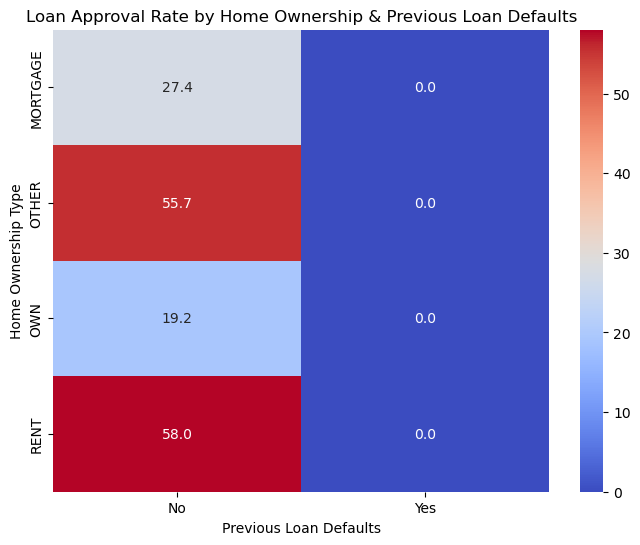

In [ ]:
plot_home_ownership_defaults_heatmap(loan_data)

> - Zero approvals for past defaulters, regardless of homeownership status.
> - Renters (58%) and "Other" homeowners (55.7%) have the highest approval rates.
> - Mortgage holders (27.4%) and homeowners (19.2%) get fewer approvals, likely due to existing financial commitments.

In [ ]:
# Categorical Feature Analysis
# Loan Amount vs. Employment Experience

def plot_loan_amount_vs_experience(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='person_emp_exp', y='loan_amnt', hue='loan_status', data=df, alpha=0.6, palette={0: 'red', 1: 'blue'})
    plt.title('Loan Amount vs. Employment Experience')
    plt.xlabel('Years of Employment Experience')
    plt.ylabel('Loan Amount')
    plt.legend(title="Loan Status", labels=["Rejected", "Approved"])
    plt.show()

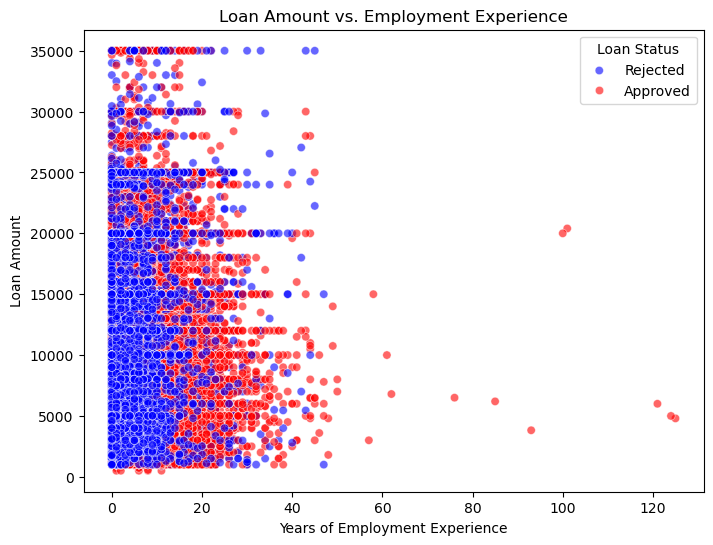

In [ ]:
plot_loan_amount_vs_experience(loan_data)

> - Most loan requests come from applicants with ≤ 20 years of experience.
> - High rejection rates exist across all experience levels, meaning tenure alone isn’t a strong approval factor.
> - Large loans (>$20K) are more likely approved for experienced applicants.